<a href="https://colab.research.google.com/github/DrMohamedElsherif/CNNmodel-ImageClassification/blob/main/myCNNmodel_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <span style="color:blue">Desigining and Training a Convolutional NN for Multi-class classification Task on Imaging Data</span>

##### <span style="color:blue">**MOHAMED ELSHERIF**</span>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

import numpy as np
import random

Please notice that if you have *mps* device on your Macbook, set the flag below to be **True**. Otherwise, *cuda* device will be tried to find.

In [ ]:
## IMPORTANT TO SET: MPS FLAG
use_mps = True

## Load the dataset

My goal is to implement a convolutional neural network for multi-class classification. I use *Fashion MNIST* dataset, which is a set of 28x28 grayscale images of clothes.

In [ ]:
def set_seed_(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if use_mps:
        if torch.backends.mps.is_available():
            torch.mps.manual_seed(seed)
    else:
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

seed = 42
set_seed_(seed)

In [ ]:
# Transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])


# Create data loaders for the training, validation, and test sets
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 19981294.95it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 406651.50it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6227804.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18518247.85it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
label_map = {0 : "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

## Define a CNN
In this section, I build up a baseline solution to the problem.

#### <span style="color:red"></span> Construct a base neural network
I construct two functions  ```create_conv_layers()``` and  ```create_fc_layers()```


In [ ]:
def create_conv_layers():
    """
    return: an object of class torch.nn.Sequential
    """

    layers = None

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # Channels are 1 because we are dealing with greyscale images
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    ##############################

    return layers

In [ ]:
def create_fc_layers():
    """
    return: an object of class torch.nn.Sequential
    """

    layers = None

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 128),  # Flattened from the last conv layer
        nn.ReLU(),
        nn.Linear(128, 10)  # 10 output classes for FashionMNIST based on the given label_map variable
    )
    ##############################

    return layers

In [ ]:

class FashionMNIST_NN(nn.Module):
    def __init__(self, conv_layers, fc_layers, hook_func=None):
        super(FashionMNIST_NN, self).__init__()
        self.conv_layers = conv_layers
        self.fc_layers = fc_layers
        if hook_func is not None:
            self.outputs = {}
            self.hooks = []
            self.hook_func = hook_func

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        # x = torch.softmax(x, dim=1) #'The correct approach when using nn.CrossEntropyLoss() is to pass the logits
                                      #'(unnormalized scores) directly to the loss function without applying torch.softmax()
                                      #'in the forward pass.
        return x

    def extract_features_(self):
        if hasattr(self, "outputs"):
            return self.outputs
        else:
            return None

    def _remove_hooks(self):
        if hasattr(self, "hooks"):
            for hook in self.hooks:
                hook.remove()
            self.hooks = []
        else:
            pass

    def reset_features(self):
        self.outputs = {}

In [ ]:

class ModelTrainer:
    def __init__(self, model, trainloader, testloader, train_params, valloader=None, hook_func=None):
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = train_params["lr"]
        if train_params["optimizer"] == "adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif train_params["optimizer"] == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            raise NotImplementedError()
        self.use_gpu = train_params["use_gpu"]
        if use_mps:
            self.device = torch.device("mps" if (torch.backends.mps.is_available() and self.use_gpu) else "cpu")
        else:
            self.device = torch.device("cuda:0" if (torch.cuda.is_available() and self.use_gpu) else "cpu")
        print("My device is:", self.device)
        self.model.to(self.device)
        self.seed = train_params["seed"]

    def set_seed(self):
        set_seed_(seed)

    def train(self, epochs=10):
        n_epochs = epochs
        train_losses, val_losses, others = [], [], []
        for epoch in range(n_epochs):
            self.model.train()
            if hasattr(self.model, "hook_func"):
                self.model.hook_func(conv_layers=self.model.conv_layers, outputs=self.model.outputs, hooks=self.model.hooks)
            running_loss = 0.0
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            train_losses.append(running_loss / len(trainloader))
            self.model._remove_hooks()

            # Validation loop
            if self.valloader is not None:
                val_loss, other = self.evaluate()
                val_losses.append(val_loss)
                others.append(other)
            print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

        return train_losses, val_losses, others

    def predict(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy}%')
        return accuracy

    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in self.valloader:
                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                loss = self.criterion(output, labels)
                val_loss += loss.item()

        return val_loss / len(valloader), None

    def get_features(self):
        return self.model.extract_features_()


In [ ]:
model_baseline = FashionMNIST_NN(create_conv_layers(),create_fc_layers())

train_params = {
    "lr": 0.001,
    "optimizer": "sgd",
    "use_gpu": True,
    "seed": 42,
}
trainer_baseline = ModelTrainer(model=model_baseline, trainloader=trainloader, testloader=testloader, train_params=train_params, valloader=valloader)
trainer_baseline.set_seed()
train_losses, val_losses,_ = trainer_baseline.train(epochs=15)

My device is: cpu
Epoch 1, Training Loss: 2.272574274698893, Validation Loss: 2.2297764471236694
Epoch 2, Training Loss: 2.0987778630256653, Validation Loss: 1.8525352877505281
Epoch 3, Training Loss: 1.3772625236511231, Validation Loss: 1.0184374289943816
Epoch 4, Training Loss: 0.8611528081893921, Validation Loss: 0.7692774575441441
Epoch 5, Training Loss: 0.7147344733476639, Validation Loss: 0.6866928224867963
Epoch 6, Training Loss: 0.6564897654851277, Validation Loss: 0.6489524464023874
Epoch 7, Training Loss: 0.621296747525533, Validation Loss: 0.6218091931114805
Epoch 8, Training Loss: 0.5966552115281423, Validation Loss: 0.5972373656770016
Epoch 9, Training Loss: 0.5777257936000824, Validation Loss: 0.5874569590421433
Epoch 10, Training Loss: 0.5601552086273829, Validation Loss: 0.5680302893544765
Epoch 11, Training Loss: 0.5468584846258163, Validation Loss: 0.5513948871100203
Epoch 12, Training Loss: 0.5330861726999283, Validation Loss: 0.5363329319243736
Epoch 13, Training Lo

In [ ]:

def plot_curves(curves, labels, xlabel='Epochs', ylabel='Loss', title='Training and Validation Loss'):
    for curve, label in zip(curves, labels):
        plt.plot(curve, label=label)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

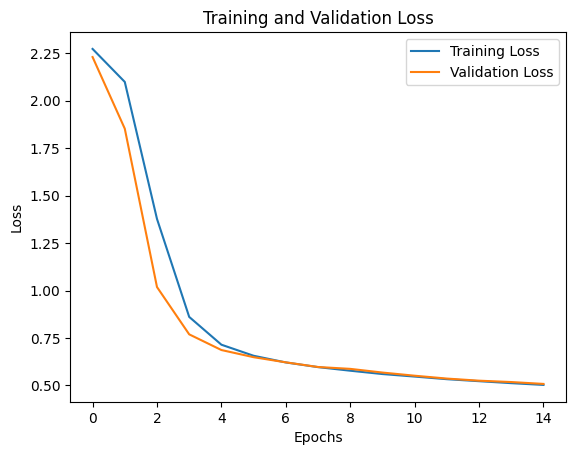

In [ ]:
plot_curves([train_losses, val_losses], ["Training Loss", "Validation Loss"])

In [ ]:
## EVALUATION
accuracy = trainer_baseline.predict()

Test Accuracy: 81.07%


#### <span style="color:red"></span> Plot the predicted results
It can be more intuitive to visualize the predicted results. so in the following cell, I implement a function that generates the true and predicted labels on top of each test image. I used colors to indicate correct and incorrect predictions.

In [ ]:
def plot_images(images, labels, preds):
    """
    only plot the first 20 images and 10 images each row
    label_map is defined in a previous cell, which can be directly accessed
    """

    ########## My Answer #########
    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.subplots_adjust(hspace=0.5, wspace=0.1)
    axes = axes.ravel()

    for i in range(20):
        img = images[i] / 2 + 0.5  # Here I unnormalized the image
        img = img.cpu().numpy().transpose(1, 2, 0)  # then Converted it from tensor to numpy array and transposed so we retrieve and plot it

        true_label = label_map[labels[i].item()]
        pred_label = label_map[preds[i].item()]

        if labels[i] == preds[i]:
            label_color = 'green'
        else:
            label_color = 'red'

        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label}', color=label_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    ##############################

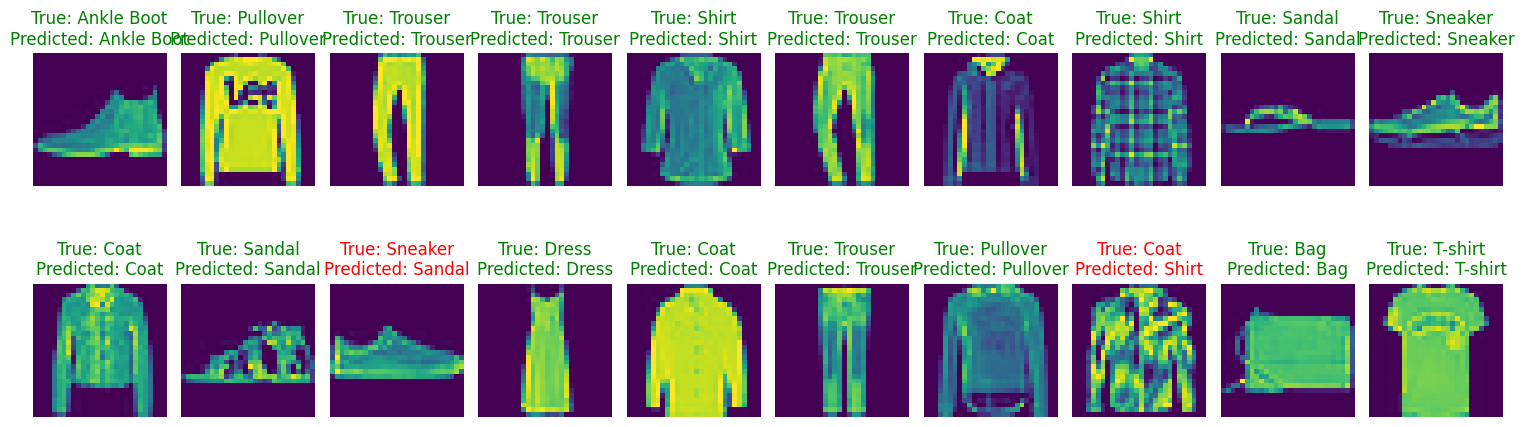

In [ ]:
# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(trainer_baseline.device), labels.to(trainer_baseline.device)

# Predict
output = model_baseline(images)
_, preds = torch.max(output, 1)

plot_images(images, labels, preds)

## Improve the model's performance
In this section, I explore different tricks utilized in Deep Learning which may be beneficial to improving my model's performance.

#### <span style="color:red"></span> Implement BatchNorm
Accordingly, Batch Normalization is said to have some advantages like improving gradient flow, reducing sensitivity to initialization, and preventing overfitting, etc. I now simply modify ```create_conv_layers()``` and ```create_fc_layers()```.

In [ ]:
def create_conv_layers():

    layers = None

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    ##############################

    return layers

def create_fc_layers():

    layers = None

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    ##############################

    return layers

My device is: cpu
Epoch 1, Training Loss: 0.8981030820210775, Validation Loss: 0.6490498137600879
Epoch 2, Training Loss: 0.5771393973032634, Validation Loss: 0.5103607345768746
Epoch 3, Training Loss: 0.4751593054533005, Validation Loss: 0.43874581411797947
Epoch 4, Training Loss: 0.4158719505667686, Validation Loss: 0.39551307253063994
Epoch 5, Training Loss: 0.37621521069606145, Validation Loss: 0.36379707160782304
Epoch 6, Training Loss: 0.3467152783870697, Validation Loss: 0.3411790795148687
Epoch 7, Training Loss: 0.3230270853837331, Validation Loss: 0.3262353133648
Epoch 8, Training Loss: 0.3043978838324547, Validation Loss: 0.311831274882276
Epoch 9, Training Loss: 0.2881966664393743, Validation Loss: 0.3013225919864279
Epoch 10, Training Loss: 0.2731052781244119, Validation Loss: 0.29017047877324387
Epoch 11, Training Loss: 0.2604491937160492, Validation Loss: 0.28246859575998273
Epoch 12, Training Loss: 0.24885092674692472, Validation Loss: 0.2779965156570394
Epoch 13, Traini

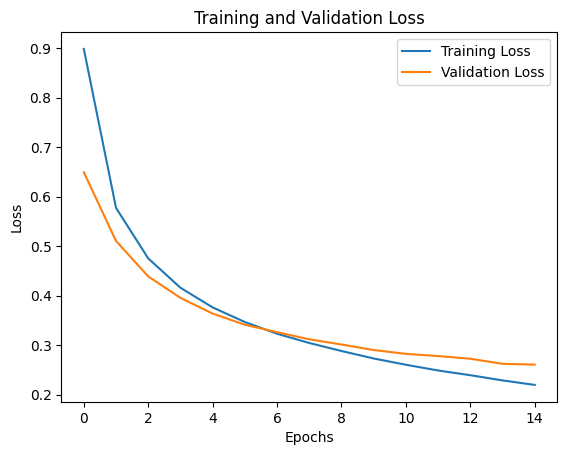

In [ ]:
# Training

########## My Answer #########
model_w_BatchN = FashionMNIST_NN(create_conv_layers(),create_fc_layers())
trainer_Base_w_Batch = ModelTrainer(model=model_w_BatchN, trainloader=trainloader, testloader=testloader, train_params=train_params, valloader=valloader)
trainer_Base_w_Batch.set_seed()
train_losses, val_losses,_ = trainer_Base_w_Batch.train(epochs=15)
##############################

plot_curves([train_losses, val_losses], ["Training Loss", "Validation Loss"])

#### <span style="color:red"></span> Switch the optimizer
In my baseline model, I used SGD optimizer. To achieve a better performance, I adjusted the learning rate for it (without modifying the number of epochs).

In [ ]:

########## My Answer #########
train_params_LRchanged = {
    "lr": 0.01,            # I adjusted to 0.01 instead of 0.001
    "optimizer": "sgd",
    "use_gpu": True,
    "seed": 42,
}
##############################

My device is: cpu
Epoch 1, Training Loss: 0.4688072817524274, Validation Loss: 0.32298453199736615
Epoch 2, Training Loss: 0.28130874660611155, Validation Loss: 0.26815735247540984
Epoch 3, Training Loss: 0.2306376770536105, Validation Loss: 0.27100949964307725
Epoch 4, Training Loss: 0.1956139756043752, Validation Loss: 0.24061939247111055
Epoch 5, Training Loss: 0.16934629355370998, Validation Loss: 0.2449176226286812
Epoch 6, Training Loss: 0.1464388771255811, Validation Loss: 0.23078165653141888
Epoch 7, Training Loss: 0.12793095386524994, Validation Loss: 0.22540286991824496
Epoch 8, Training Loss: 0.11028795455147823, Validation Loss: 0.2420730230774968
Epoch 9, Training Loss: 0.09422025112559398, Validation Loss: 0.2332640895223681
Epoch 10, Training Loss: 0.07972628595928351, Validation Loss: 0.24176118075055011
Epoch 11, Training Loss: 0.07026694356153408, Validation Loss: 0.24169538425717582
Epoch 12, Training Loss: 0.05757382683952649, Validation Loss: 0.24596724262897005
Ep

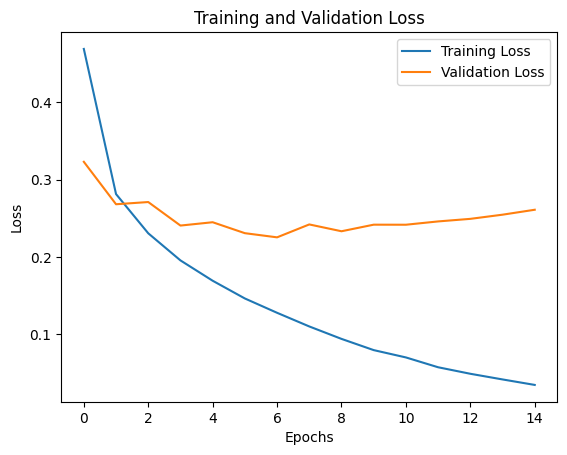

In [ ]:
# SGD WITH THE LEARNING RATE
# Training

########## My Answer #########
model_w_BatchN = FashionMNIST_NN(create_conv_layers(),create_fc_layers())
trainer_Base_w_Batch_LRchanged = ModelTrainer(model=model_w_BatchN, trainloader=trainloader, testloader=testloader, train_params=train_params_LRchanged, valloader=valloader)
trainer_Base_w_Batch_LRchanged.set_seed()
train_losses, val_losses,_ = trainer_Base_w_Batch_LRchanged.train(epochs=15)
##############################

plot_curves([train_losses, val_losses], ["Training Loss", "Validation Loss"])

In [ ]:
# Evaluation
accuracy = None

########## My Answer #########
accuracy = trainer_Base_w_Batch_LRchanged.predict()
##############################

Test Accuracy: 91.67%


An alternative approach is to switch to Adam optimizer without changing the initial learning rate.

My device is: cpu
Epoch 1, Training Loss: 0.34549195257822674, Validation Loss: 0.2502217630835924
Epoch 2, Training Loss: 0.22995164487262568, Validation Loss: 0.22975296707467197
Epoch 3, Training Loss: 0.1893531318033735, Validation Loss: 0.22876208903703918
Epoch 4, Training Loss: 0.15868316903462013, Validation Loss: 0.21459134448161152
Epoch 5, Training Loss: 0.13168654399613539, Validation Loss: 0.21836295160167712
Epoch 6, Training Loss: 0.10539741982519626, Validation Loss: 0.23176200142962503
Epoch 7, Training Loss: 0.08773057656238477, Validation Loss: 0.2258696840293309
Epoch 8, Training Loss: 0.07045213335938752, Validation Loss: 0.24870771779975992
Epoch 9, Training Loss: 0.056802732502420746, Validation Loss: 0.255462845628883
Epoch 10, Training Loss: 0.04544860345280419, Validation Loss: 0.25090124606689873
Epoch 11, Training Loss: 0.03980768152295301, Validation Loss: 0.2797018463445946
Epoch 12, Training Loss: 0.032840768980793654, Validation Loss: 0.3024334143847227


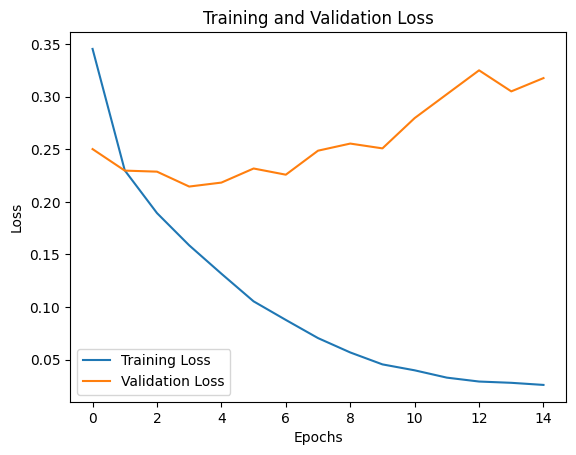

In [ ]:
# Switching to ADAM Optimizer

# Training
model_Adam = None
train_losses, val_losses = None, None

########## My Answer #########
model_Adam = {
    "lr": 0.001,
    "optimizer": "adam",
    "use_gpu": True,
    "seed": 42,
}
model_w_BatchN = FashionMNIST_NN(create_conv_layers(),create_fc_layers())
trainer_Base_w_Batch_Adam = ModelTrainer(model=model_w_BatchN, trainloader=trainloader, testloader=testloader, train_params=model_Adam, valloader=valloader)
trainer_Base_w_Batch_Adam.set_seed()
train_losses, val_losses,_ = trainer_Base_w_Batch_Adam.train(epochs=15)
##############################

plot_curves([train_losses, val_losses], ["Training Loss", "Validation Loss"])

#### <span style="color:red"></span> Analyse the results


In [ ]:
# FIRST OF ALL,
# The loss curves indicate that the model initially learns well from the training data, but around epoch 5-6, it starts to overfit.
# Overfitting is evidenced by the increasing validation loss while the training loss continues to decrease. This is also
# particularly evident in the plot which shows a widening gap between the training and validation loss indicating a significant generalization gap, and a struggle to generalize to
# new validating data.

While the test accuracy is good, however, the validation loss is increasingly large. So now I will investigate how the validation accuracy develops thoughout training. I do this by creating a subclass of ```ModelTrainer``` and by modifying the validation function (I use List *others* to store validation accuracy).

In [ ]:
# NEW SUBCLASS

########## My Answer #########
class ModelTrainerWithValidationAccuracy(ModelTrainer):
    def __init__(self, model, trainloader, testloader, train_params, valloader=None, hook_func=None):
        super().__init__(model, trainloader, testloader, train_params, valloader, hook_func)
        self.val_accuracy = []  # Initialize an empty list to store validation accuracy

    def train(self, epochs=10):
        n_epochs = epochs
        train_losses, val_losses, others = [], [], []

        for epoch in range(n_epochs):
            self.model.train()
            if hasattr(self.model, "hook_func"):
                self.model.hook_func(conv_layers=self.model.conv_layers, outputs=self.model.outputs, hooks=self.model.hooks)

            running_loss = 0.0
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(self.trainloader))
            self.model._remove_hooks()

            # Validation loop
            if self.valloader is not None:
                val_loss, _ = self.evaluate()
                val_losses.append(val_loss)

                # Compute validation accuracy
                val_acc = self.compute_accuracy(self.valloader)
                self.val_accuracy.append(val_acc)
                others.append(val_acc)  # Store validation accuracy for plotting

            print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {self.val_accuracy[-1]}')

        return train_losses, val_losses, others

    def compute_accuracy(self, dataloader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy
##############################

My device is: cpu
Epoch 1, Training Loss: 0.02565809727498951, Validation Loss: 0.33590733828865227, Validation Accuracy: 0.9220833333333334
Epoch 2, Training Loss: 0.01907967300429785, Validation Loss: 0.3407562484864413, Validation Accuracy: 0.9276666666666666
Epoch 3, Training Loss: 0.018880126745401262, Validation Loss: 0.3492233369204072, Validation Accuracy: 0.9236666666666666
Epoch 4, Training Loss: 0.0182099033552513, Validation Loss: 0.34872323673149136, Validation Accuracy: 0.9255
Epoch 5, Training Loss: 0.015333672632075225, Validation Loss: 0.34699679651555226, Validation Accuracy: 0.92825
Epoch 6, Training Loss: 0.01906130904884776, Validation Loss: 0.35314493892872906, Validation Accuracy: 0.9248333333333333
Epoch 7, Training Loss: 0.012600661797487797, Validation Loss: 0.3622187568776389, Validation Accuracy: 0.92675
Epoch 8, Training Loss: 0.01530810304529344, Validation Loss: 0.3728886361028306, Validation Accuracy: 0.92325
Epoch 9, Training Loss: 0.0143105106385968, V

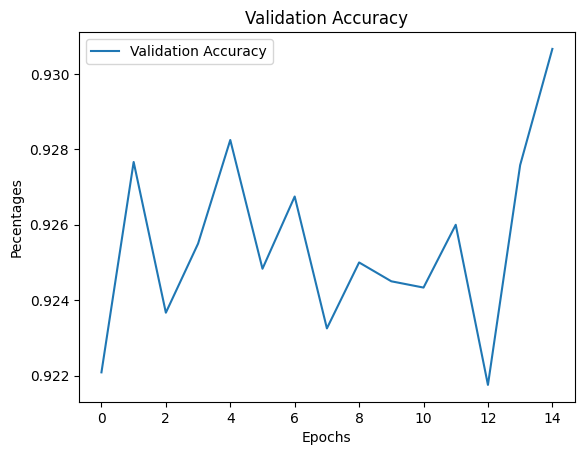

In [ ]:
# Training
train_losses, val_losses, val_accuracy = None, None, None


########## My Answer #########
# Create an new instance for the new subclass ModelTrainerWithValidationAccuracy
trainer_Base_w_Batch_Adam_w_Accuracy = ModelTrainerWithValidationAccuracy(model=model_w_BatchN,
                                                          trainloader=trainloader,
                                                          testloader=testloader,
                                                          valloader=valloader,
                                                          train_params=model_Adam)

# Training the model
train_losses, val_losses, val_accuracy = trainer_Base_w_Batch_Adam_w_Accuracy.train(epochs=15)
##############################

plot_curves([val_accuracy], ["Validation Accuracy"], xlabel='Epochs', ylabel='Pecentages', title='Validation Accuracy')

In [ ]:
# I observe that the validation accuracy is improving overall, suggesting that the model is able to generalize well to unseen data. However, there are noticeable fluctuations
# in the accuracy from one epoch to another, which might indicate instability in the model's performance over time, and the validation loss consistently exceeds
# the training loss, which is typically a sign of overfitting.
# To both imporve stability and mitigate overfitting, we can use techniques such regularization (L1 or L2), dropout, or early stopping.

#### <span style="color:red"></span> Solve a common problem in Deep Learning


In [ ]:
# To solve the above problem, I chose "Dropout" as a technique to imporve model's stability and mitigate overfitting.

In [ ]:
def create_conv_layers():
    # YOUR CODE HERE
    layers = None
    #raise NotImplementedError()

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),  # Adding Dropout with 0.25 probability as an arbitrary value (The entire notebook takes full 5 hours to run!, so testing several values was time-consuming)
                             # The GPU limit of colab was exceeded after a just few runs and could not longer use it! which limited my ability to explore all possible ideas/solutions in mind!

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    ##############################

    return layers

def create_fc_layers():
    # YOUR CODE HERE
    layers = None
    #raise NotImplementedError()

    ########## My Answer #########
    layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.5),  # Dropout with 0.5 probability higher than in the Conv.layer to effectively mitigate risk of overfitting as FC layers are more prone to overfitting.
        nn.Linear(128, 10)
    )
    ##############################

    return layers

My device is: cpu
Epoch 1, Training Loss: 0.4767881405353546, Validation Loss: 0.30018525527037204
Epoch 2, Training Loss: 0.335526508529981, Validation Loss: 0.2658778090782939
Epoch 3, Training Loss: 0.30106832066178324, Validation Loss: 0.2414201976176589
Epoch 4, Training Loss: 0.2813955344657103, Validation Loss: 0.23252774087434752
Epoch 5, Training Loss: 0.2613131470878919, Validation Loss: 0.22749688361394912
Epoch 6, Training Loss: 0.2496511787623167, Validation Loss: 0.22002811979581702
Epoch 7, Training Loss: 0.23569390446941058, Validation Loss: 0.21074860403314233
Epoch 8, Training Loss: 0.22615126878023148, Validation Loss: 0.212943725233422
Epoch 9, Training Loss: 0.21859201186895372, Validation Loss: 0.20970934304468175
Epoch 10, Training Loss: 0.21077221749226252, Validation Loss: 0.20106398906717274
Epoch 11, Training Loss: 0.20387745368480684, Validation Loss: 0.2078924388525651
Epoch 12, Training Loss: 0.1935422519793113, Validation Loss: 0.20616507366735567
Epoch 1

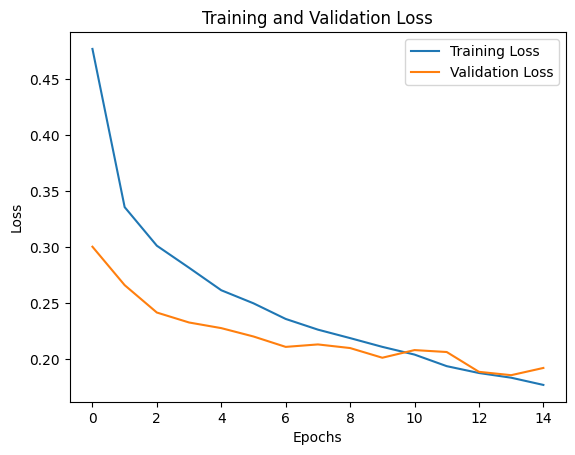

In [ ]:
# ADAM WITH THE DROPOUT TRICK)

# Training

########## My Answer #########
# Training
model_w_BatchN_w_Dropout = FashionMNIST_NN(create_conv_layers(),create_fc_layers())
trainer_Base_w_Batch_Adam_w_Dropout = ModelTrainer(model=model_w_BatchN_w_Dropout, trainloader=trainloader, testloader=testloader, train_params=model_Adam, valloader=valloader)
trainer_Base_w_Batch_Adam_w_Dropout.set_seed()
train_losses, val_losses,_ = trainer_Base_w_Batch_Adam_w_Dropout.train(epochs=15)
##############################

plot_curves([train_losses, val_losses], ["Training Loss", "Validation Loss"])

In [ ]:
# Evaluation
accuracy = None

########## My Answer #########
accuracy = trainer_Base_w_Batch_Adam_w_Dropout.predict()
##############################

# FINAL COMMENT # As you can see from the plot above, after applying the Dropout, the values for Training and Validation losses are now too close to each other indicating that
# the model's performance is stable across both the training and validation sets. This stability also implies that the model is not overfitting or underfitting.

Test Accuracy: 92.72%


Here is another visualization tool which can be helpful to understand the incorrect predictions.

In [ ]:
def view_class_probs(img, ps, truth_label):

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))

    labels = ['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot']
    colors = ['black'] * 10
    colors[truth_label] = 'red'

    ax2.set_yticklabels(labels, size='small')

    for color,tick in zip(colors,ax2.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

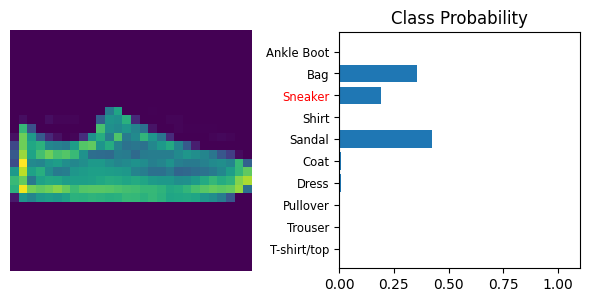

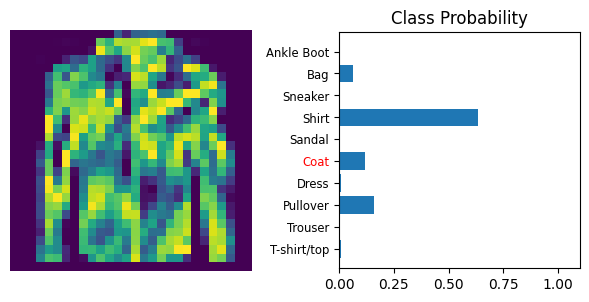

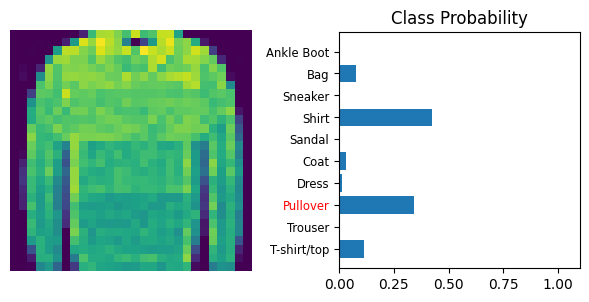

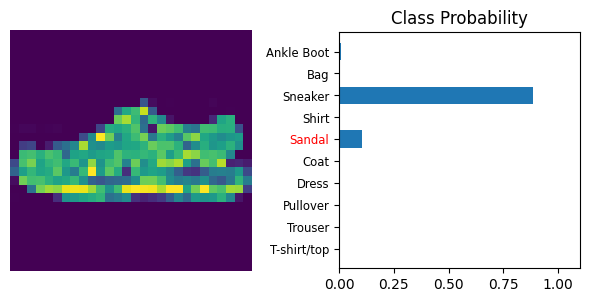

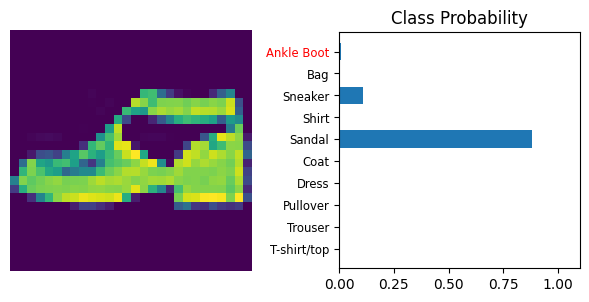

In [ ]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(trainer_baseline.device), labels.to(trainer_baseline.device)

# Predict
output = model_baseline(images)
probs = torch.softmax(output, 1)
probs = probs.detach().cpu().numpy()

counts = 0
for i in range(probs.shape[0]):
    if (labels[i].detach().cpu().numpy() != np.argmax(probs[i])) and counts <= 4:
        view_class_probs(images[i].cpu(), probs[i], labels[i].detach().cpu().numpy().item())
        counts +=1

**Conclusion:** Through this small project, I constructed a CNN for multi-class classification task that achieves a test accuracy of 92%